- last week we learnt the rolling model
- this week we would learn ensemble methods and intraday trading

In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

In [3]:
product_list = ["IF", "IH", "IC", "T", "TF"]

In [4]:
period = 4096

In [5]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1092

1092

In [6]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [7]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [9]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [60]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV,RidgeCV

from sklearn.preprocessing import StandardScaler
#y_signal = "ret."+str(period)+".004"
y_signal = "ret."+str(period)

In [11]:
## get multiple samples of the singal matrix
def get_multiple_sample_signal(good_night_files, sample, product, signal_name, period, daily_num, mod=np.array([0])):
    n_samples = int(sum(daily_num[sample])) ## number of samples
    n_mod = len(mod) ## number of different copies of the same signal
    if n_mod==1: ## if there is one copy then the same as before
        all_signal = np.zeros(n_samples)
    else:
        all_signal = np.zeros((n_mod, n_samples)) ## if there are multiple copies then use a matrix for one signal instead
    cur = 0
    for file in good_night_files[sample]: ## iterate for files
        good = load(SAVE_PATH+"/good pkl/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[good]
        for i in range(n_mod):
            signal = S[(np.arange(len(S))+1) % period == mod[i]]
            ## the ret.cor has some bad records
            signal[np.isnan(signal)] = 0
            signal[np.isinf(signal)] = 0
            if mod[i]==0: 
                cur_end = np.min((cur+len(signal),n_samples)) ## to avoid exceed the number of samoes, mod[i]==0 has most signals, 
                ## so if it doesn't exceed, others would not exceed
            if n_mod==1:
                all_signal[cur:cur_end] = signal[0:(cur_end-cur)]
            else:
                all_signal[i, cur:cur_end] = signal[0:(cur_end-cur)]
        cur = cur_end
    return all_signal

In [12]:
mod = np.arange(0, np.floor(period/10)*10, np.floor(period/10))
n_mod = len(mod)
mod
## array([   0.,  409.,  818., 1227., 1636., 2045., 2454., 2863., 3272.,
##        3681.])

array([   0.,  409.,  818., 1227., 1636., 2045., 2454., 2863., 3272.,
       3681.])

In [13]:
SAVE_PATH = "e:/intern"
os.makedirs(SAVE_PATH+"/train test array", exist_ok=True)

In [15]:
## save the result into a 3-d array, i*j*k, i is for different mod, j*k is the signal matrix for one mod
%%time
for product in product_list[0:3]:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    n_train = sum(daily_num[train_sample])
    n_test = sum(daily_num[test_sample])
    train_array = np.zeros((n_mod, int(n_train), n_signal+1))
    for i in range(n_signal):
        train_array[:,:,i] = get_multiple_sample_signal(all_dates, train_sample, product, signal_list[i], period, daily_num, mod)
    train_array[:,:,n_signal] = get_multiple_sample_signal(all_dates, train_sample, product, "ret."+str(period), period, daily_num, mod)
    save(train_array, SAVE_PATH+"/train test array/"+product+".train.array.pkl")
    
# Wall time: 0 ns
# IF
# IH
# IC



Wall time: 0 ns
IF
IH
IC


In [19]:
all_train_array = dict([])
for product in product_list[0:3]:
    all_train_array[product] = load(SAVE_PATH+"/train test array/"+product+".train.array.pkl")

In [22]:
## get the result of 10 models
## save them in to a model_coef dictionary
nfold = 10
model_coef = dict([])
for product in product_list[0:3]:
    model_coef[product] = np.zeros(n_signal)
for i_mod in range(n_mod):
    train_std_mat = dict([])
    x_train = np.zeros((0, n_signal))
    y_train = np.array([])
    for product in product_list[0:3]:
        cur_mat = all_train_array[product][i_mod,:,:]
        train_std_mat[product] = np.std(cur_mat, axis=0)
        x_train = np.vstack((x_train, cur_mat[:,:n_signal]/train_std_mat[product][:n_signal]))
        y_train = np.concatenate((y_train, cur_mat[:,n_signal]/train_std_mat[product][n_signal]))
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = model.coef_/x_std
    for product in product_list[0:3]:
        coef = fit_coef*train_std_mat[product][n_signal]/train_std_mat[product][:n_signal]
        model_coef[product] = model_coef[product]+coef/n_mod


d:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.301838227557255, tolerance: 0.4257559910729113
  tol, rng, random, positive)
d:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.246004519942289, tolerance: 0.4257559910729113
  tol, rng, random, positive)
d:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2569845534490014, tolerance: 0.5170788284441861
  tol, rng, random, positive)
d:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

In [23]:
save(model_coef, SAVE_PATH+"/index.ensemble.model.pkl")

In [24]:
 model_coef = load(SAVE_PATH+"/index.ensemble.model.pkl")

In [25]:
model_coef

# {'IF': array([ 5.20617442e-03, -1.32082917e-03,  4.34078174e-03,  4.22629922e-03,
#         -2.44406024e-04,  1.28238911e-04, -8.74944520e-02,  3.73774325e-05,
#         -2.50779981e-04, -9.81489324e-05, -5.72657230e-05, -6.70004061e-05,
#          2.29338315e-05,  2.84696121e-05,  6.64782938e-06,  2.28666714e-04,
#         -6.35241448e-06,  2.01713080e-06, -2.62140053e-05,  3.27181564e-04,
#         -1.06727696e-03, -8.43983101e-05,  5.33521391e-05,  1.21634170e-04,
#          0.00000000e+00,  2.45632616e-06, -9.98044998e-05, -1.20639069e-02,
#          2.37894628e-03,  1.43072104e-02,  1.86323882e-02,  1.57208616e-03,
#         -1.97546058e-03, -2.49490950e-01,  1.82822554e-03,  2.73296356e-03,
#         -4.19264631e-04, -5.80345752e-04,  2.38997322e-03, -7.81616959e-03,
#         -6.87915230e-04, -1.09573671e-03,  1.62192843e-01,  3.49879709e-04,
#          3.19642345e-04]),
#  'IH': array([ 5.63931043e-03, -1.29436514e-03,  5.05782849e-03,  5.14594707e-03,
#         -2.40627300e-04,  1.30459124e-04, -8.40520850e-02,  3.81275867e-05,
#         -2.68881707e-04, -1.61917808e-04, -8.35617365e-05, -9.84257377e-05,
#          5.16677304e-05,  4.14911637e-05,  9.68105762e-06,  3.24469207e-04,
#         -8.15527277e-06,  3.16555967e-06,  6.10173396e-04,  1.43939786e-04,
#         -1.68066959e-03, -1.42624517e-03,  6.79939704e-05,  1.66530127e-04,
#          0.00000000e+00,  3.07105788e-06, -1.21990421e-04, -1.07264173e-02,
#          2.02928118e-03,  1.38333823e-02,  1.75578975e-02,  1.27503212e-03,
#         -1.69548284e-03, -2.06885918e-01,  1.53736057e-03,  2.31568784e-03,
#         -5.40283360e-04, -7.68656052e-04,  2.70660531e-03, -8.67385671e-03,
#         -6.59331155e-04, -1.15285755e-03,  1.58095875e-01,  3.61017093e-04,
#          3.28832201e-04]),
#  'IC': array([ 7.99012049e-03, -1.80977145e-03,  5.71027532e-03,  7.58519821e-03,
#         -3.01392200e-04,  1.50793485e-04, -8.24888052e-02,  4.65103566e-05,
#         -3.32476112e-04, -5.58099302e-05, -2.87220767e-05, -2.63883924e-05,
#          2.74473240e-05,  1.56918581e-05,  3.52795999e-06,  8.10539652e-05,
#         -3.12249181e-06,  9.64494286e-07,  8.99301619e-05,  8.27683200e-05,
#         -5.19173650e-04, -7.31369510e-04,  2.53461623e-05,  6.13108262e-05,
#          0.00000000e+00,  9.54504290e-07, -4.34529328e-05, -1.42468617e-02,
#          2.24418397e-03,  1.48553845e-02,  2.26123344e-02,  1.70287896e-03,
#         -2.13369997e-03, -1.91021040e-01,  2.03265068e-03,  3.01784512e-03,
#         -8.06090662e-04, -8.29814638e-04,  2.89222390e-03, -1.34771691e-02,
#         -8.50844156e-04, -1.38666334e-03,  1.52975954e-01,  4.47262162e-04,
#          4.17148286e-04])}

{'IF': array([ 5.20617442e-03, -1.32082917e-03,  4.34078174e-03,  4.22629922e-03,
        -2.44406024e-04,  1.28238911e-04, -8.74944520e-02,  3.73774325e-05,
        -2.50779981e-04, -9.81489324e-05, -5.72657230e-05, -6.70004061e-05,
         2.29338315e-05,  2.84696121e-05,  6.64782938e-06,  2.28666714e-04,
        -6.35241448e-06,  2.01713080e-06, -2.62140053e-05,  3.27181564e-04,
        -1.06727696e-03, -8.43983101e-05,  5.33521391e-05,  1.21634170e-04,
         0.00000000e+00,  2.45632616e-06, -9.98044998e-05, -1.20639069e-02,
         2.37894628e-03,  1.43072104e-02,  1.86323882e-02,  1.57208616e-03,
        -1.97546058e-03, -2.49490950e-01,  1.82822554e-03,  2.73296356e-03,
        -4.19264631e-04, -5.80345752e-04,  2.38997322e-03, -7.81616959e-03,
        -6.87915230e-04, -1.09573671e-03,  1.62192843e-01,  3.49879709e-04,
         3.19642345e-04]),
 'IH': array([ 5.63931043e-03, -1.29436514e-03,  5.05782849e-03,  5.14594707e-03,
        -2.40627300e-04,  1.30459124e-04, -8.4052

In [29]:
strat = "ensemble.lasso."+str(period)
for product in product_list[0:3]:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [30]:
%%time
for product in product_list[0:3]:
    print(product)
    coef = model_coef[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")

# IF
# IH
# IC
# Wall time: 21min 59s



IF
IH
IC
Wall time: 21min 59s


In [31]:
%%time
for product in product_list[0:3]:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

## Wall time: 2min 7s


Wall time: 1min 22s


In [32]:
%%time
for product in product_list[0:3]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("ensemble.lasso", all_dates, product, 10, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                    period=4096, split_str="2018", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# Wall time: 4min 54s



reverse=1
reverse=1
reverse=1
Wall time: 4min 54s


IF train sharpe  0.47150096604325553 test sharpe  -0.037315443318655814
IH train sharpe  nan test sharpe  nan
IC train sharpe  0.9228920399125531 test sharpe  0.5376474912169934
train sharpe:  nan test sharpe:  nan


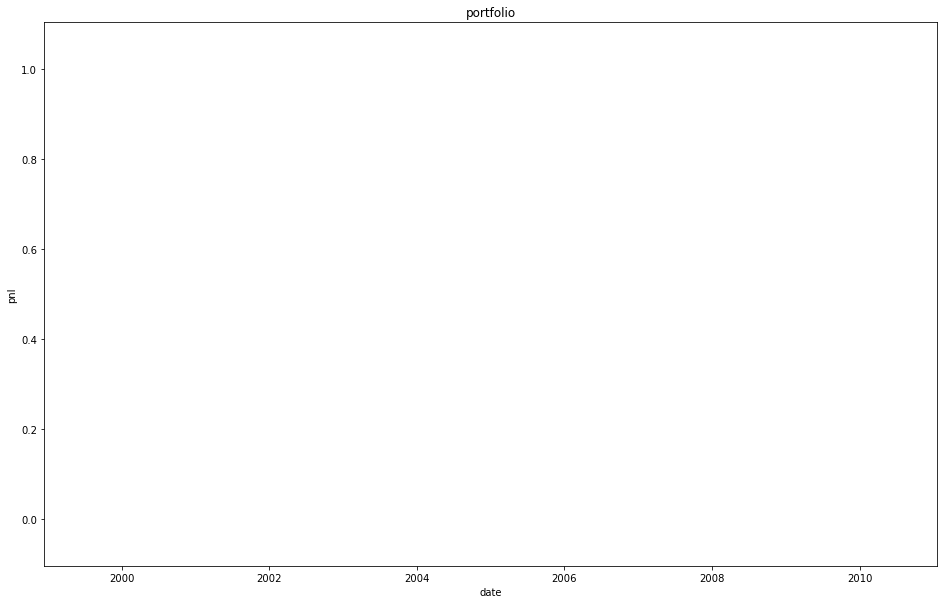

In [35]:
i = 0
strat = "ensemble.lasso.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list[:3])])
train_all_pnl = np.zeros([sum(train_sample), len(product_list[:3])])
min_pnl = 2
min_num = 10
for product in product_list[:3]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    


# IF train sharpe  0.47150096604325553 test sharpe  -0.037315443318655814
# IH train sharpe  nan test sharpe  nan
# IC train sharpe  0.9228920399125531 test sharpe  0.5376474912169934
# train sharpe:  nan test sharpe:  nan


- it's not as good as thre model in week 9
- maybe we can use another way of ensemble
- we can generate 10 separate models with each pnl

In [36]:
## generate 10 different models, and save their coefficients rather than calcualte their mean
nfold = 10
model_coef = dict([])
for i_mod in range(n_mod):
    train_std_mat = dict([])
    model_coef[str(i_mod)] = dict([])
    x_train = np.zeros((0, n_signal))
    y_train = np.array([])
    for product in product_list[0:3]:
        cur_mat = all_train_array[product][i_mod,:,:]
        train_std_mat[product] = np.std(cur_mat, axis=0)
        x_train = np.vstack((x_train, cur_mat[:,:n_signal]/train_std_mat[product][:n_signal]))
        y_train = np.concatenate((y_train, cur_mat[:,n_signal]/train_std_mat[product][n_signal]))
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = model.coef_/x_std
    for product in product_list[:3]:
        coef = fit_coef*train_std_mat[product][n_signal]/train_std_mat[product][:n_signal]
        model_coef[str(i_mod)][product] = coef


d:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.301838227557255, tolerance: 0.4257559910729113
  tol, rng, random, positive)
d:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.246004519942289, tolerance: 0.4257559910729113
  tol, rng, random, positive)
d:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2569845534490014, tolerance: 0.5170788284441861
  tol, rng, random, positive)
d:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

In [38]:
save(model_coef, SAVE_PATH+"index.ensemble.all.coef.pkl")

In [40]:
for i_mod in range(n_mod):
    print(i_mod)
    strat = "ensemble.lasso."+str(i_mod)+"."+str(period)
    for product in product_list[:3]:
        os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
        coef = model_coef[str(i_mod)][product]
        parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
                  product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
        par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")    
        spread = product_info[product]["spread"]
        tranct = product_info[product]["tranct"]
        tranct_ratio = product_info[product]["tranct.ratio"]
        evaluate_signal("ensemble.lasso."+str(i_mod), all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                        period=4096, split_str="2018", tranct=tranct, 
                        max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

0
reverse=1
reverse=1
reverse=1
1
reverse=1
reverse=1
reverse=1
2
reverse=1
reverse=1
reverse=1
3
reverse=1
reverse=1
reverse=1
4
reverse=1
reverse=1
reverse=1
5
reverse=1
reverse=1
reverse=1
6
reverse=1
reverse=1
reverse=1
7
reverse=1
reverse=1
reverse=1
8
reverse=1
reverse=1
reverse=1
9
reverse=1
reverse=1
reverse=1


In [41]:
min_pnl = 2
min_num = 10
all_portfolio = np.zeros((sum(test_sample)+sum(train_sample),n_mod))
for i_mod in range(n_mod):
    strat = "ensemble.lasso."+str(i_mod)+"."+str(period)
    i = 0
    test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
    train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
    for product in product_list[0:3]:
        spread = product_info[product]["spread"]
        signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
        train_stat = signal_stat["train.stat"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        if sum(good_strat)==0:
            test_pnl = np.zeros(sum(test_sample))
            train_pnl = np.zeros(sum(train_sample))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
    train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
    test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
    all_portfolio[:,i_mod] = np.append(train_portfolio, test_portfolio)

# IF train sharpe  nan test sharpe  nan
# IH train sharpe  nan test sharpe  nan
# IC train sharpe  nan test sharpe  nan
# IF train sharpe  0.673413675635718 test sharpe  -0.4192435606240424
# IH train sharpe  0.14184886401122412 test sharpe  -0.6590623833255
# IC train sharpe  0.42416607055972966 test sharpe  0.05112053179955243
# IF train sharpe  0.525713652216129 test sharpe  -0.14669268829930893
# IH train sharpe  0.4040148259497696 test sharpe  0.3922282696267237
# IC train sharpe  1.0157979241441288 test sharpe  0.9130796260023097
# IF train sharpe  nan test sharpe  nan
# IH train sharpe  0.6996676431635704 test sharpe  0.13001523585526742
# IC train sharpe  0.5662114171023233 test sharpe  0.7478924546420906
# IF train sharpe  0.5649726544517604 test sharpe  0.16539412552248053
# IH train sharpe  0.7538759332690589 test sharpe  0.7255274051011044
# IC train sharpe  0.32934027627934165 test sharpe  0.9026666665763917
# IF train sharpe  0.4128913197737153 test sharpe  0.566937939502815
# IH train sharpe  0.29617294821312085 test sharpe  -0.1371435274458121
# IC train sharpe  0.4269097547893075 test sharpe  0.8162820897614285
# IF train sharpe  0.6620368182985833 test sharpe  -0.7255431370841071
# IH train sharpe  0.27867540515553935 test sharpe  -0.8541912357758152
# IC train sharpe  0.3337400848008789 test sharpe  -0.8538566751576998
# IF train sharpe  0.7677877697227384 test sharpe  0.6803169401125256
# IH train sharpe  nan test sharpe  nan
# IC train sharpe  1.3811484440910662 test sharpe  0.576718279518038
# IF train sharpe  0.45790471319931364 test sharpe  0.8467178134884396
# IH train sharpe  nan test sharpe  nan
# IC train sharpe  0.13668595203985578 test sharpe  -0.011810974135071702
# IF train sharpe  nan test sharpe  nan
# IH train sharpe  nan test sharpe  nan
# IC train sharpe  nan test sharpe  nan

IF train sharpe  nan test sharpe  nan
IH train sharpe  nan test sharpe  nan
IC train sharpe  nan test sharpe  nan
IF train sharpe  0.673413675635718 test sharpe  -0.4192435606240424
IH train sharpe  0.14184886401122412 test sharpe  -0.6590623833255
IC train sharpe  0.42416607055972966 test sharpe  0.05112053179955243
IF train sharpe  0.525713652216129 test sharpe  -0.14669268829930893
IH train sharpe  0.4040148259497696 test sharpe  0.3922282696267237
IC train sharpe  1.0157979241441288 test sharpe  0.9130796260023097
IF train sharpe  nan test sharpe  nan
IH train sharpe  0.6996676431635704 test sharpe  0.13001523585526742
IC train sharpe  0.5662114171023233 test sharpe  0.7478924546420906
IF train sharpe  0.5649726544517604 test sharpe  0.16539412552248053
IH train sharpe  0.7538759332690589 test sharpe  0.7255274051011044
IC train sharpe  0.32934027627934165 test sharpe  0.9026666665763917
IF train sharpe  0.4128913197737153 test sharpe  0.566937939502815
IH train sharpe  0.296172948

train sharpe:  1.076342817470515 test sharpe:  0.3242845990046131


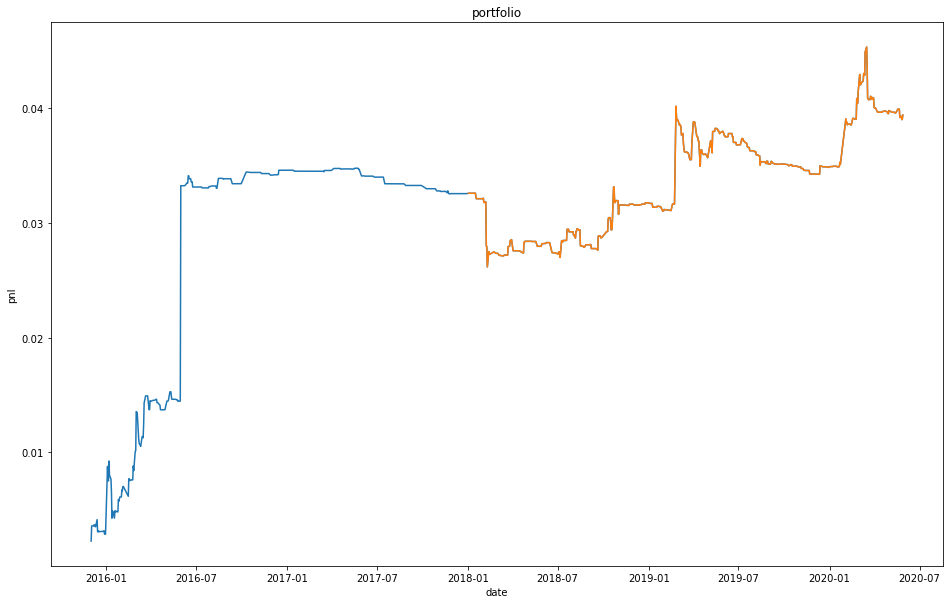

In [43]:
portfolio = np.mean(all_portfolio, axis=1)
train_portfolio = portfolio[train_sample]
test_portfolio = portfolio[test_sample]
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date")
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, portfolio.cumsum());
plt.plot(format_dates[test_sample], portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))   

# train sharpe:  1.7811680723531234 test sharpe:  1.5854930989700786


- we can see that the rolling ensemble model much better than train/test


- now we go for the next part: the intraday medium frequency trading

    
- at this time, we do not need to close position every day
- and we cannot use parallel computing for daily pnl because one day's pnl depends on previous position
- but we can still use parallel for each contract because they are independent


- now let's first find the days of each contract

In [44]:
def get_contract(file):
    data = load(file)
    return data["contract"][data["good"]].iloc[0]

In [45]:
contract_list=dict([])
for product in product_list[0:3]:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    contract_vec = pd.Series(list(map(get_contract, file_list)))
    save(contract_vec, HEAD_PATH+"/"+product+".contract.vec.pkl")
    contract_list[product] = contract_vec

In [46]:
save(contract_list, HEAD_PATH+"/index.contract.list.pkl")

In [48]:
contract_list = load(HEAD_PATH+"/index.contract.list.pkl")
product_cum = dict([])
product_len = dict([])
for product in product_list[0:3]:
    contract_vec = contract_list[product]
    contract_len = contract_vec.value_counts().sort_index()
    contract_cum = contract_len.cumsum()
    product_len[product] = contract_len
    product_cum[product] = contract_cum

- we know that lasso.4096 is trained using data before 2018
- however our contract is not splited in this way
- so we may need to comply to the data of this format

In [49]:
train_sample_list = dict([])
test_sample_list = dict([])
for product in product_list[0:3]:
    contract_cum = product_cum[product]
    split_date = all_dates[contract_cum[np.max(np.where(all_dates[contract_cum-1]<"2018"))]]
    medium_train_sample = (all_dates<split_date)
    medium_test_sample = (all_dates>=split_date)
    train_sample_list[product] = medium_train_sample
    test_sample_list[product] = medium_test_sample

In [61]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list[0:3]:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [97]:
y_signal = "ret."+str(period)

In [98]:
train_std = dict([])
all_x_train = dict([])
all_y_train = dict([])
n_sample = 0
for product in product_list[0:3]:
    medium_train_sample = train_sample_list[product]
    medium_test_sample = test_sample_list[product]
    medium_train_range = range(round(sum((daily_ticks[product][medium_train_sample]))))
    medium_test_range = np.arange(sum(daily_ticks[product][medium_train_sample])+1,sum(daily_ticks[product]))
    medium_train_mat = all_mat[product].iloc[medium_train_range,:]
    medium_test_mat = all_mat[product].iloc[medium_test_range,:]
    x_train = medium_train_mat.iloc[:,:n_signal]
    y_train = medium_train_mat[y_signal]
    train_std[product] = np.std(medium_train_mat)
    all_x_train[product] = x_train
    all_y_train[product] = y_train
    n_sample = n_sample+len(y_train)

In [99]:
x_train = np.zeros((n_sample, n_signal))
y_train = np.zeros(n_sample)
cur = 0
for product in product_list[0:3]:
    x_train[cur:(cur+len(all_y_train[product])),] = all_x_train[product]/train_std[product][:n_signal]
    y_train[cur:(cur+len(all_y_train[product]))] = all_y_train[product]/train_std[product][y_signal]
    cur = cur+len(all_y_train[product])

In [104]:
model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train, y_train)
#model = RidgeCV(fit_intercept=False, cv=5).fit(x_train, y_train)
fit_coef = model.coef_
fit_coef

# array([-0.        , -0.        ,  0.        , -0.        ,  0.        ,
#         0.        ,  0.        ,  0.        ,  0.        , -0.        ,
#        -0.        , -0.        , -0.        , -0.        ,  0.        ,
#        -0.        , -0.        , -0.        , -0.01172248, -0.00282502,
#        -0.        , -0.        , -0.        ,  0.        , -0.        ,
#        -0.        , -0.        , -0.        , -0.        ,  0.        ,
#        -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
#         0.        , -0.        , -0.        ,  0.        ,  0.        ,
#         0.        ,  0.        , -0.        ,  0.        ,  0.        ])

array([-0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.01172248, -0.00282502,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ])

In [105]:
coef_list=dict([])
for product in product_list[:3]:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][:n_signal]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])

# IF
# trade.imb.std.4096         -0.000336
# total.trade.imb.std.4096   -0.000039
# dtype: float64
# IH
# trade.imb.std.4096         -0.000738
# total.trade.imb.std.4096   -0.000065
# dtype: float64
# IC
# trade.imb.std.4096         -0.000179
# total.trade.imb.std.4096   -0.000020
# dtype: float64

IF
trade.imb.std.4096         -0.000336
total.trade.imb.std.4096   -0.000039
dtype: float64
IH
trade.imb.std.4096         -0.000738
total.trade.imb.std.4096   -0.000065
dtype: float64
IC
trade.imb.std.4096         -0.000179
total.trade.imb.std.4096   -0.000020
dtype: float64


- here we use ridge because lasso is not good

In [106]:
strat = "lasso.medium."+str(period)
#strat = "ridge.medium."+str(period)
SAVE_PATH = "e:/intern"

In [107]:
for product in product_list[0:3]:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [108]:
%%time
for product in product_list[0:3]:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH=SAVE_PATH)

# IF
# IH
# IC
# Wall time: 21min 52s


IF
IH
IC
Wall time: 22min 41s


In [109]:
%%time
for product in product_list[0:3]:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

#Wall time: 1min 22s

Wall time: 1min 23s


In [110]:
close_thre_list = dict([])
for product in product_list[0:3]:
    all_signal = load(SAVE_PATH+"/all signal/"+product+"."+strat+".pkl")
    open_thre = np.quantile(abs(all_signal), np.concatenate((np.arange(0.991, 0.999, 0.001),
                                                         np.arange(0.9991,0.9999,0.0001)),axis=0))
    thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))
    from collections import OrderedDict
    import itertools
    open_list=open_thre
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    close_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    close_thre_list[product] = close_thre_mat


In [111]:
contract_vec = dict([])
contract_start = dict([])
for product in product_list[0:3]:
    contract_vec[product] = np.array(product_cum[product].index)
    contract_start[product] = np.hstack((0, product_cum[product].values))


In [112]:
## backtest strategy within a contract
## need not to close position at the end of day
## need to get the position at the end of day and calculate the overnight holding pnl
def get_signal_pnl_contract(contract, contract_vec, good_night_files, product, signal_name, thre_mat, 
                                    slippage=1, fee=0.1, reverse=1, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    file_list = good_night_files[contract_vec==contract]
    n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    ## load product info
    tranct = product_info[product]["tranct"]*(1+fee)
    close = product_info[product]["close"]*(1+fee)
    min_spread = product_info[product]["spread"]+0.1
    spread = product_info[product]["spread"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    
    yesterday_pos = np.repeat(0, n_thre)
    yesterday_notional = np.repeat(0., n_thre)
    yesterday_price = 0.
    n_day = len(file_list)
    daily_pnl = np.zeros((n_day, n_thre))
    daily_ret = np.zeros((n_day, n_thre))
    for i_day in range(n_day):
        file = file_list[i_day]
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        data = data[data["good"]].reset_index(drop=True)
        n_bar = len(data)
        ## load signal
        ## we don't know the signal is positive correlated or negative correlated  
        pred = S*reverse
        
        bid_ask_spread = data["ask"]-data["bid"]
        next_spread = bid_ask_spread.shift(-1)
        next_spread.iloc[-1] = bid_ask_spread.iloc[-1]
        #not_trade = (data["time"]=="10:15:00") | (data["time"]=="11:30:00") | (data["time"]=="15:00:00") | (bid_ask_spread>min_spread) | (next_spread>min_spread)
        not_trade = (data["time"]=="11:30:00") | (data["time"]=="15:00:00") | (bid_ask_spread>min_spread) | (next_spread>min_spread)
            
        next_ask = data["next.ask"].values
        next_bid = data["next.bid"].values
          
        i_thre = 0 
        for thre in thre_mat.values:
            buy = pred>thre[0]
            sell = pred<-thre[0]
            signal = pd.Series(data=0, index=data.index)
            #position = signal.copy()
            signal[buy] = 1
            signal[sell] = -1
            signal[not_trade] = 0
            scratch = -thre[1]
            position_pos = pd.Series(data=np.nan, index=data.index)
            position_pos[(signal==1) & (next_ask>0) & (next_bid>0)] = 1
            position_pos[(pred< -scratch) & (next_bid>0)] = 0
            position_pos.iloc[0] = max((0, yesterday_pos[i_thre]))
            position_pos.ffill(inplace=True)
            pre_pos = position_pos.shift(1)
            notional_position_pos = pd.Series(data=np.nan, index=data.index)
            notional_position_pos[position_pos==1] = 1
            notional_position_pos[0] = np.nan
            notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
            notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
            notional_position_pos[(pred< -scratch) & (next_bid>0)] = 0
            notional_position_pos.iloc[0] = max((0, yesterday_notional[i_thre]))
            notional_position_pos.ffill(inplace=True)
            position_neg = pd.Series(data=np.nan, index=data.index)
            position_neg[(signal==-1) & (next_ask>0) & (next_bid>0)] = -1
            position_neg[(pred> scratch) & (next_ask>0)] = 0
            position_neg.iloc[0] = min((yesterday_pos[i_thre], 0))
            position_neg.ffill(inplace=True)
            pre_neg = position_neg.shift(1)
            notional_position_neg = pd.Series(data=np.nan, index=data.index)
            notional_position_neg[position_neg==-1] = -1
            notional_position_neg[0] = np.nan
            notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
            notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
            notional_position_neg[(pred> scratch) & (next_ask>0)] = 0
            notional_position_neg.iloc[0] = min((yesterday_notional[i_thre], 0))
            notional_position_neg.ffill(inplace=True)
            position = position_pos + position_neg
            notional_position = notional_position_pos+notional_position_neg
            position.loc[0] = yesterday_pos[i_thre]
            notional_position[0] = yesterday_notional[i_thre]
            if file == file_list[-1]:
                position.iloc[-10:] = 0
                notional_position.iloc[-10:] = 0
            else:
                position.iloc[-10:] = position.iloc[-10]
                notional_position.iloc[-10:] = notional_position.iloc[-10]
            initial_pnl = yesterday_pos[i_thre]*yesterday_price
            initial_notional_pnl = yesterday_notional[i_thre]*yesterday_price
            change_pos = position - position.shift(1)
            change_pos.iloc[0] = 0
            notional_change_pos = notional_position-notional_position.shift(1)
            notional_change_pos.iloc[0] = 0
            pre_pos = position.shift(1)
            pre_pos.iloc[0] = position.iloc[0]
            change_base = pd.Series(data=0, index=data.index)
            change_buy = change_pos>0
            change_sell = change_pos<0
            if (tranct_ratio):
                change_base[change_buy] = (data["next.ask"][change_buy]+spread*slippage)*(1+tranct)
                change_base[change_sell] = (data["next.bid"][change_sell]-spread*slippage)*(1-tranct)
            else:
                change_base[change_buy] = data["next.ask"][change_buy]+tranct+spread*slippage
                change_base[change_sell] = data["next.bid"][change_sell]-tranct-spread*slippage
            notional_change_base = pd.Series(data=0, index=data.index)
            notional_change_buy = notional_change_pos>0
            notional_change_sell = notional_change_pos<0
            if (tranct_ratio):
                notional_change_base[notional_change_buy] = (data["next.ask"][notional_change_buy]+spread*slippage)*(1+tranct)
                notional_change_base[notional_change_sell] = (data["next.bid"][notional_change_sell]-spread*slippage)*(1-tranct)
            else:
                notional_change_base[notional_change_buy] = data["next.ask"][notional_change_buy]+tranct+spread*slippage
                notional_change_base[notional_change_sell] = data["next.bid"][notional_change_sell]-tranct-spread*slippage

            yesterday_pos[i_thre] = position.iloc[-1]
            yesterday_notional[i_thre] = notional_position.iloc[-1]
            final_pnl = -sum(change_base*change_pos)+data["price"].iloc[-1]*yesterday_pos[i_thre]-initial_pnl
            daily_pnl[i_day, i_thre] = final_pnl
            ## add the overnight pnl
            ret = -sum(notional_change_base*notional_change_pos)+data["price"].iloc[-1]*yesterday_notional[i_thre]-initial_notional_pnl
            daily_ret[i_day, i_thre] = ret
            num = sum((position!=0) & (change_pos!=0))
            result.loc[i_thre, ("num")] = result.loc[i_thre, ("num")]+num
            result.loc[i_thre, ("pnl")] = result.loc[i_thre, ("pnl")]+final_pnl
            result.loc[i_thre, ("ret")] = result.loc[i_thre, ("ret")]+ret
            if result.loc[i_thre, ("num")] == 0:
                result.loc[i_thre, ("avg.pnl")] = 0
                result.loc[i_thre, ("avg.ret")] = 0
            else:
                result.loc[i_thre, ("avg.pnl")] = np.divide(result.loc[i_thre, ("pnl")], result.loc[i_thre, ("num")])
                result.loc[i_thre, ("avg.ret")] = np.divide(result.loc[i_thre, ("ret")], result.loc[i_thre, ("num")])
            i_thre = i_thre + 1
        yesterday_price = data["price"].iloc[-1]
    os.makedirs(SAVE_PATH+"/medium strat/"+product+"/"+signal_name, exist_ok=True)
    save((result, daily_pnl, daily_ret), SAVE_PATH+"/medium strat/"+product+"/"+signal_name+"/"+contract+".pkl")

In [113]:
%%time
for product in product_list[0:3]:
    print(product)
    result = parLapply(CORE_NUM, contract_vec[product], get_signal_pnl_contract, 
                       contract_vec=contract_list[product], good_night_files=all_dates, product=product, 
                       signal_name=strat, thre_mat=close_thre_list[product])

# IF
# IH
# IC
# Wall time: 46min 14s



IF
IH
IC
Wall time: 42min 55s


- then we can select good signals from training samples

In [114]:
train_contract_list = dict([])
test_contract_list = dict([])
for product in product_list[0:3]:
    last_contract = contract_list[product][np.max(np.where(train_sample_list[product]))]
    train_contract_list[product] = contract_vec[product][contract_vec[product]<=last_contract]
    test_contract_list[product] = contract_vec[product][contract_vec[product]>last_contract]

In [115]:
train_stat_list = dict([])
for product in product_list[:3]:
    train_stat = OrderedDict([("final.result", None), ("daily.ret", None)])
    train_contract = train_contract_list[product]
    for contract in train_contract:
        (result, daily_pnl, daily_ret) = load(SAVE_PATH+"/medium strat/"+product+"/"+strat+"/"+contract+".pkl")
        if train_stat["final.result"] is None:
            train_stat["final.result"] = result
        else:
            train_stat["final.result"]["num"] = train_stat["final.result"]["num"] + result["num"]
            train_stat["final.result"]["pnl"] = train_stat["final.result"]["pnl"] + result["pnl"]
            train_stat["final.result"]["ret"] = train_stat["final.result"]["ret"] + result["ret"]
            train_stat["final.result"]["avg.pnl"] = zero_divide(train_stat["final.result"]["pnl"], train_stat["final.result"]["num"])
            train_stat["final.result"]["avg.ret"] = zero_divide(train_stat["final.result"]["ret"], train_stat["final.result"]["num"])

        if train_stat["daily.ret"] is None:
            train_stat["daily.ret"] = daily_ret
        else:
            train_stat["daily.ret"] = np.vstack((train_stat["daily.ret"], daily_ret))
    train_stat_list[product] = train_stat

In [116]:
test_stat_list = dict([])
for product in product_list[:3]:
    test_stat = OrderedDict([("final.result", None), ("daily.ret", None)])
    test_contract = test_contract_list[product]
    for contract in test_contract:
        (result, daily_pnl,daily_ret) = load(SAVE_PATH+"/medium strat/"+product+"/"+strat+"/"+contract+".pkl")
        if test_stat["final.result"] is None:
            test_stat["final.result"] = result
        else:
            test_stat["final.result"]["num"] = test_stat["final.result"]["num"] + result["num"]
            test_stat["final.result"]["pnl"] = test_stat["final.result"]["pnl"] + result["pnl"]
            test_stat["final.result"]["ret"] = test_stat["final.result"]["ret"] + result["ret"]
            test_stat["final.result"]["avg.pnl"] = zero_divide(test_stat["final.result"]["pnl"], test_stat["final.result"]["num"])
            test_stat["final.result"]["avg.ret"] = zero_divide(test_stat["final.result"]["ret"], test_stat["final.result"]["num"])

        if test_stat["daily.ret"] is None:
            test_stat["daily.ret"] = daily_ret
        else:
            test_stat["daily.ret"] = np.vstack((test_stat["daily.ret"], daily_ret))
    test_stat_list[product] = test_stat

In [119]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list[:3])])
train_all_pnl = np.zeros([sum(train_sample), len(product_list[:3])])
min_pnl = 2
min_num = 10
for product in product_list[:3]:
    spread = product_info[product]["spread"]
    train_stat = train_stat_list[product]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = test_stat_list[product]
    test_pnl = test_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1

# IF train sharpe  0.18572100146562645 test sharpe  -0.2705716183649813
# IH train sharpe  0.873847970966251 test sharpe  -0.92997752412203
# IC train sharpe  1.0856068131696932 test sharpe  -0.06327488175229085



IF train sharpe  0.4317391959476006 test sharpe  -0.3665273417382336
IH train sharpe  nan test sharpe  nan
IC train sharpe  0.7103472744461646 test sharpe  -0.2768176393351883


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


IF train sharpe  0.4317391959476006 test sharpe  -0.3665273417382336
IH train sharpe  nan test sharpe  nan
IC train sharpe  0.7103472744461646 test sharpe  -0.2768176393351883
train sharpe:  nan test sharpe:  nan


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


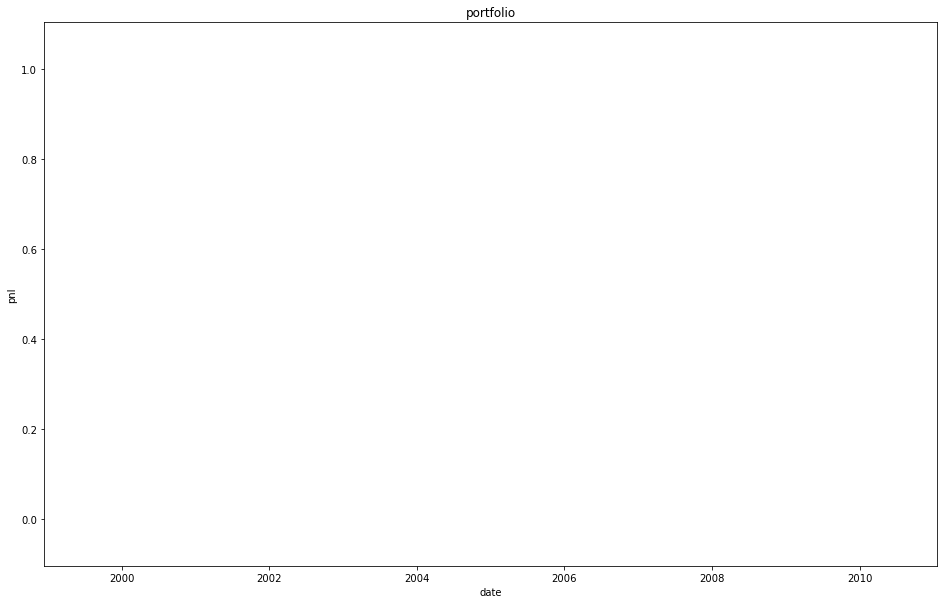

In [120]:
i = 0
all_pnl = np.zeros([n_days, len(product_list[:3])])
min_pnl = 2
min_num = 10
for product in product_list[:3]:
    spread = product_info[product]["spread"]
    train_stat = train_stat_list[product]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    test_stat = test_stat_list[product]
    test_pnl = test_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    all_pnl[:len(train_pnl),i] = train_pnl
    all_pnl[len(train_pnl):n_days,i] = test_pnl
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1
all_portfolio = np.array(np.mean(all_pnl, axis=1))
train_portfolio = all_portfolio[train_sample]
test_portfolio = all_portfolio[test_sample]
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# IF train sharpe  0.4317391959476006 test sharpe  -0.3665273417382336
# IH train sharpe  nan test sharpe  nan
# IC train sharpe  0.7103472744461646 test sharpe  -0.2768176393351883
# train sharpe:  nan test sharpe:  nan





- we can see that the test result accpetable even though there is a small drawback
